In [1]:
library("ggplot2")
library("dplyr")
library("RColorBrewer")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Prediction vs. experimental violin plots by chromatin state

In [2]:
GeomSplitViolin <- ggproto("GeomSplitViolin", GeomViolin, draw_group = function(self, data, ..., draw_quantiles = NULL){
  data <- transform(data, xminv = x - violinwidth * (x - xmin), xmaxv = x + violinwidth * (xmax - x))
  grp <- data[1,'group']
  newdata <- plyr::arrange(transform(data, x = if(grp%%2==1) xminv else xmaxv), if(grp%%2==1) y else -y)
  newdata <- rbind(newdata[1, ], newdata, newdata[nrow(newdata), ], newdata[1, ])
  newdata[c(1,nrow(newdata)-1,nrow(newdata)), 'x'] <- round(newdata[1, 'x']) 
  if (length(draw_quantiles) > 0 & !scales::zero_range(range(data$y))) {
    stopifnot(all(draw_quantiles >= 0), all(draw_quantiles <= 
                                              1))
    quantiles <- create_quantile_segment_frame(data, draw_quantiles)
    aesthetics <- data[rep(1, nrow(quantiles)), setdiff(names(data), c("x", "y")), drop = FALSE]
    aesthetics$alpha <- rep(1, nrow(quantiles))
    both <- cbind(quantiles, aesthetics)
    quantile_grob <- GeomPath$draw_panel(both, ...)
    ggplot2:::ggname("geom_split_violin", grobTree(GeomPolygon$draw_panel(newdata, ...), quantile_grob))
  }
  else {
    ggplot2:::ggname("geom_split_violin", GeomPolygon$draw_panel(newdata, ...))
  }
})

geom_split_violin <- function (mapping = NULL, data = NULL, stat = "ydensity", position = "identity", ..., draw_quantiles = NULL, trim = TRUE, scale = "area", na.rm = FALSE, show.legend = NA, inherit.aes = TRUE) {
  layer(data = data, mapping = mapping, stat = stat, geom = GeomSplitViolin, position = position, show.legend = show.legend, inherit.aes = inherit.aes, params = list(trim = trim, scale = scale, draw_quantiles = draw_quantiles, na.rm = na.rm, ...))
}

In [3]:
df = read.csv('../plots/preds/performanceByChromatinState.csv', header = TRUE)
head(df)

X,ChromatinState,Score,Type
0,Promoter,-0.7799314,Experimental
1,Promoter,-1.5330588,Experimental
2,Promoter,-0.5332031,Experimental
3,Promoter,-1.8759550,Experimental
4,Promoter,-0.4656997,Experimental
5,Promoter,-0.1539614,Experimental


Saving 6.67 x 6.67 in image


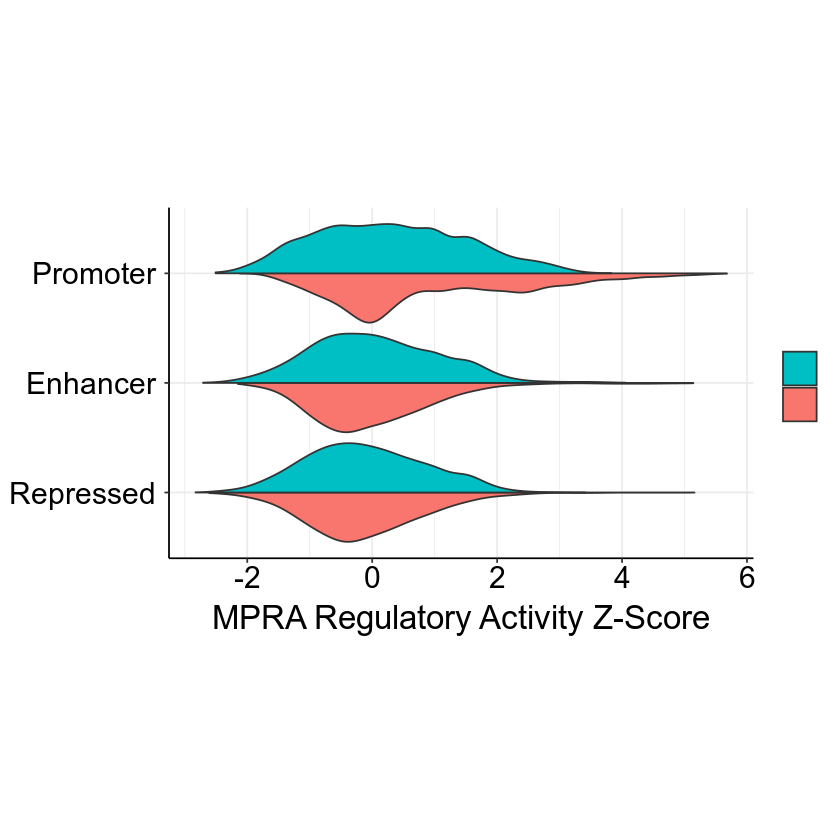

In [4]:
taskOrder = c('Repressed', 'Enhancer', 'Promoter')
sortedDf <- arrange(df, order(match(df$ChromatinState, taskOrder)))
sortedDf$ChromatinState <- factor(sortedDf$ChromatinState, levels = taskOrder, ordered = TRUE)

taskOrder = c('Predicted', 'Experimental')
sortedDf2 <- arrange(sortedDf, order(match(df$Type, taskOrder)))
sortedDf2$Type <- factor(sortedDf2$Type, levels = taskOrder, ordered = TRUE)

sortedDf2$Type <- factor(sortedDf2$Type, levels=c("Predicted", "Experimental"), labels=c("Predicted", "Experimental"))

# cols = c('#E44D3D', '#238BC3')
p <- ggplot(sortedDf2, aes(x = ChromatinState, y = Score, fill = Type)) +
        geom_split_violin(bw = 0.2, scale = 'width') +
        labs(y = "MPRA Regulatory Activity Z-Score", x = "")
p <- p + coord_flip()
p <- p + theme_bw()
p <- p + theme(aspect.ratio = 0.6)
# p <- p + scale_fill_manual(values=cols, breaks=c("Experimental", "Predicted"))
p <- p + scale_fill_discrete(breaks=c("Experimental", "Predicted"))
p <- p + theme(
               panel.border = element_blank(),
               axis.line = element_line(colour = "black"),
               legend.title=element_blank(),
               legend.key.size=unit(0.037, 'npc'),
               legend.text=element_text(size=0),
#                legend.position=c(1, 0.5),
               legend.justification=c(0.9, 0.5),
               legend.text.align = 0.0,
#                legend.justification=c(1, 1)
#                legend.background=element_rect(fill='white', size=0.3, colour='grey'),
               axis.title.x = element_text(size=20),
               axis.title.y = element_blank(),
               axis.text=element_text(size=18, colour='#000000'),
               axis.text.y = element_text(angle = 0)
            )
p <- p + guides(fill=guide_legend(
                 keywidth=0.3,
                 keyheight=0.3,
                 default.unit="inch")
      )
p <- p + theme(axis.text.y = element_text(margin = margin(t = 0, r = 5, b = 0, l = 0)))
p <- p + theme(axis.title.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)))
p

ggsave("../plots/preds/violinplot_promenhrepr_allcorrectstates_jul18.png",
       scale = 1,
       plot = p,
       units = "in", dpi=1000)

# Variant scoring-related figures

In [54]:
df = read.csv('../variant_scoring/LDL_gwasNatGenet/plotData/snpScores_all_5e3_sigNotSig_5e6.csv', header = TRUE)
head(df)

X,abspercent,absscore,greyedout,ldblocksize,neglogp,notsig,percent,pval,score,sig,sigclass,tagId,topId,volcanoend
11,136.09123,0.21238774,False,99,0.598599459,True,136.09123,0.2520,0.21238774,False,0,rs3748816,rs28690427,True
12,41.30069,0.20296958,False,6,0.006035002,True,41.30069,0.9862,0.20296958,False,0,rs4648383,rs1456461,True
13,13.02585,0.09274209,False,4,0.043591429,True,-13.02585,0.9045,-0.09274209,False,0,rs2842924,rs2842923,True
14,158.81566,0.29877275,False,20,0.337998121,True,158.81566,0.4592,0.29877275,False,0,rs689565,rs118047044,False
16,46.27509,0.12676352,False,4,0.290560426,True,46.27509,0.5122,0.12676352,False,0,rs2483230,rs79971748,True
17,12.54568,0.03401890,False,1,0.116679322,True,-12.54568,0.7644,-0.03401890,False,0,rs12139206,rs56327544,True


Saving 6.67 x 6.67 in image


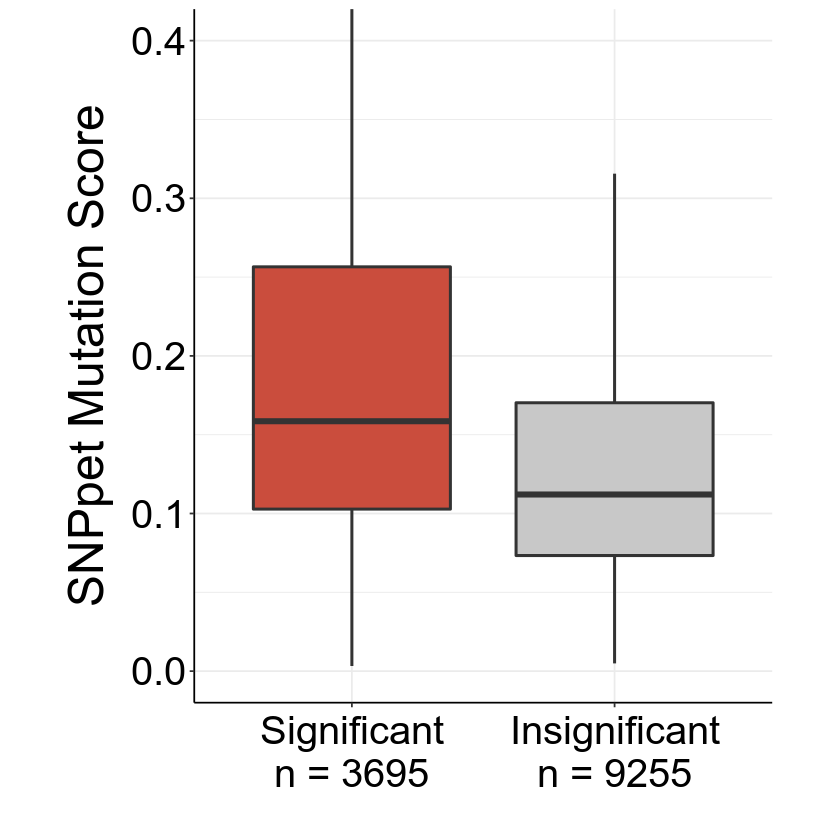

In [217]:
cols <- c('#CA4D3D', '#C8C8C8')
# cols <- c('#696969', '#C8C8C8')
# cols <- c('#E44D3D', '#238BC3')

p <- ggplot(df, aes(x = notsig, y = absscore, fill = notsig)) +
        geom_boxplot(outlier.shape = NA, lwd=0.85) + 
        coord_cartesian(ylim = c(0, 0.4)) +
        labs(x = '', y = 'SNPpet Mutation Score')
p <- p + scale_fill_manual(values=cols)
p <- p + scale_x_discrete(labels=c('Significant\nn = 3695', 'Insignificant\nn = 9255'))
p <- p + theme_bw()
p <- p + theme(
               panel.border = element_blank(),
            )
p <- p + theme(aspect.ratio=1.2)
p <- p + theme(
               axis.line = element_line(colour = "black"),
               axis.title=element_text(size=28.8),
               axis.text=element_text(size=24, colour='#000000'),
            )
p <- p + guides(fill=FALSE, color=FALSE)
p <- p + theme(axis.text.x = element_text(margin = margin(t = 5, r = 0, b = 0, l = 0)))
p <- p + theme(axis.title.y = element_text(margin = margin(t = 0, r = 15, b = 0, l = 0)))
p

ggsave("../plots/variant_scoring/sigVsNotSigBoxplot_5e6_sep23.png",
       scale = 1,
       plot = p,
       units = "in", dpi=1000)

In [203]:
df = read.csv('../variant_scoring/LDL_gwasNatGenet/plotData/snpScores_all_5e3_showEdges_corrected.csv', header = TRUE)
head(df)

X,abspercent,absscore,colored,disease,ldblocksize,neglogp,notsig,percent,pval,score,show,sig,sigclass,tagId,topId,volcanoend
0,76.75146,0.16143413,False,Not Significant,33,2.312917,False,-76.75146,0.004865,-0.16143413,True,False,-1,rs263526,rs193020084,True
1,33.55543,0.13183722,False,Not Significant,19,2.592609,False,33.55543,0.002555,0.13183722,True,False,-1,rs903908,rs190850980,True
2,51.81241,0.07137136,False,Not Significant,5,2.762708,False,51.81241,0.001727,0.07137136,True,False,-1,rs2503699,rs2460002,True
3,51.81241,0.07137136,False,Not Significant,5,2.905878,False,51.81241,0.001242,0.07137136,True,False,-1,rs2503706,rs2460002,True
4,161.06458,0.10578597,False,Not Significant,14,2.308742,False,161.06458,0.004912,0.10578597,True,False,-1,rs1692580,rs696094,True
5,211.95709,0.13135459,False,Not Significant,14,2.924818,False,-211.95709,0.001189,-0.13135459,True,False,-1,rs260505,rs186624158,True


Saving 6.67 x 6.67 in image


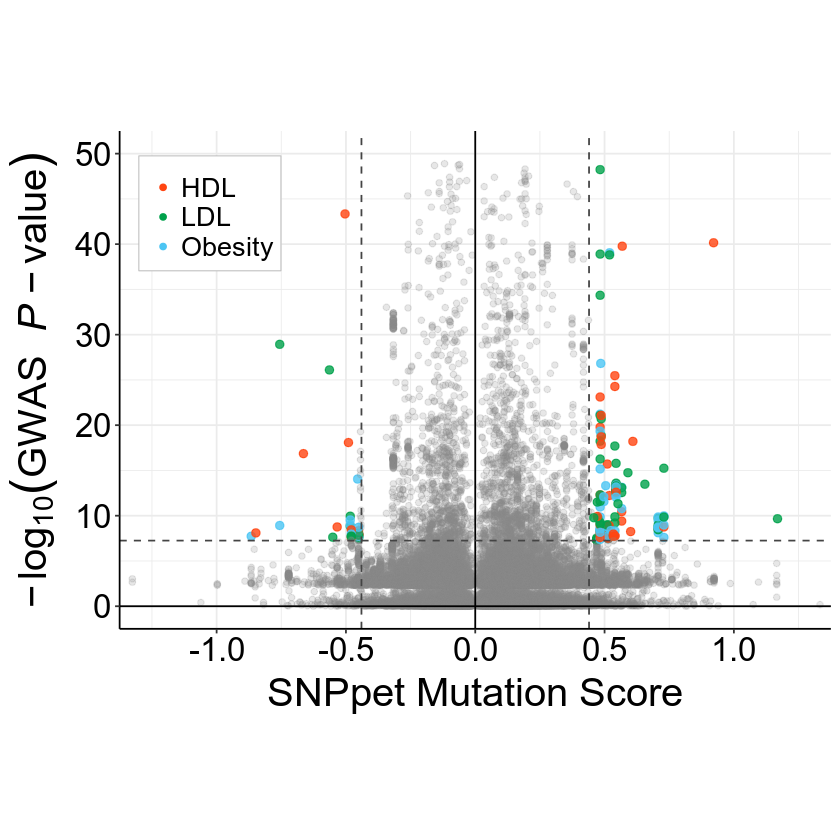

In [212]:
# cols = c('#f8766d', '#619cff', '#444444', '#00ba38')
cols = c('#ff4512', '#00a14b', '#888888', '#4cc5f3')
# cols = c('#ff4512', '#00a14b', '#4cc5f3')
p <- ggplot(df, aes(x = score, y = neglogp, alpha = disease, size = disease)) +
#         geom_point(aes(fill = disease), color = 'black', shape = 21, size = 2, stroke = 0.5) + 
#         scale_fill_manual(values = cols) +
        geom_point(aes(color = disease)) +
        coord_cartesian(xlim = c(-1.25, 1.25), ylim = c(0, 50)) +
        geom_hline(yintercept = 0, linetype = 1) +
        geom_vline(xintercept = 0, linetype = 1) +
        geom_hline(yintercept = 7.25, linetype = 2, color = '#444444') +
        geom_vline(xintercept = 0.44, linetype = 2, color = '#444444') +
        geom_vline(xintercept = -0.44, linetype = 2, color = '#444444') +
        scale_alpha_manual(values = c(0.8, 0.8, 0.2, 0.8)) +
        scale_size_manual(values = c(2, 2, 1.5, 2)) +
        labs(x = 'SNPpet Mutation Score', y = expression(-log["10"](GWAS~~italic('P')-value)))
p <- p + theme_bw()
p <- p + theme(aspect.ratio=0.7)
p <- p + guides(alpha=FALSE, size=FALSE)
p <- p + scale_color_manual(values = cols, breaks = c("HDL", "LDL", "Obesity"))
p <- p + theme(
               panel.border = element_blank(),
               axis.line = element_line(colour = "black"),
               legend.title=element_blank(),
               legend.key.size=unit(0.037, 'npc'),
               legend.text=element_text(size=16),
               legend.position=c(0.027, 0.95),
               legend.justification=c(0, 1),
               legend.text.align = 0.0,
               legend.background=element_rect(fill='white', size=0.3, colour='grey'),
               axis.title=element_text(size=24),
               axis.text=element_text(size=20, colour='#000000'),
            )
p <- p + theme(axis.title.y = element_text(margin = margin(t = 0, r = 8, b = 0, l = 0)))
p <- p + theme(axis.title.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)))
p

ggsave("../plots/variant_scoring/volcanoPlot_corrected_5e3_0.2_0.45_7.3_sep23.png",
       scale = 1,
       plot = p,
       units = "in", dpi=1000)

# Barplot of promoter/enhancer ratios

In [3]:
df = read.csv('../plots/deeplift/regGrammars/promEnhZScores_sep17removeP53.csv', header = TRUE)
head(df)

X,ratio,tf
9,2.613194,Sp1
26,2.577788,NRF1
8,2.356513,KLF14
12,2.258734,KLF3
10,2.217241,Sp5
15,1.806061,ZBTB33


Saving 6.67 x 6.67 in image


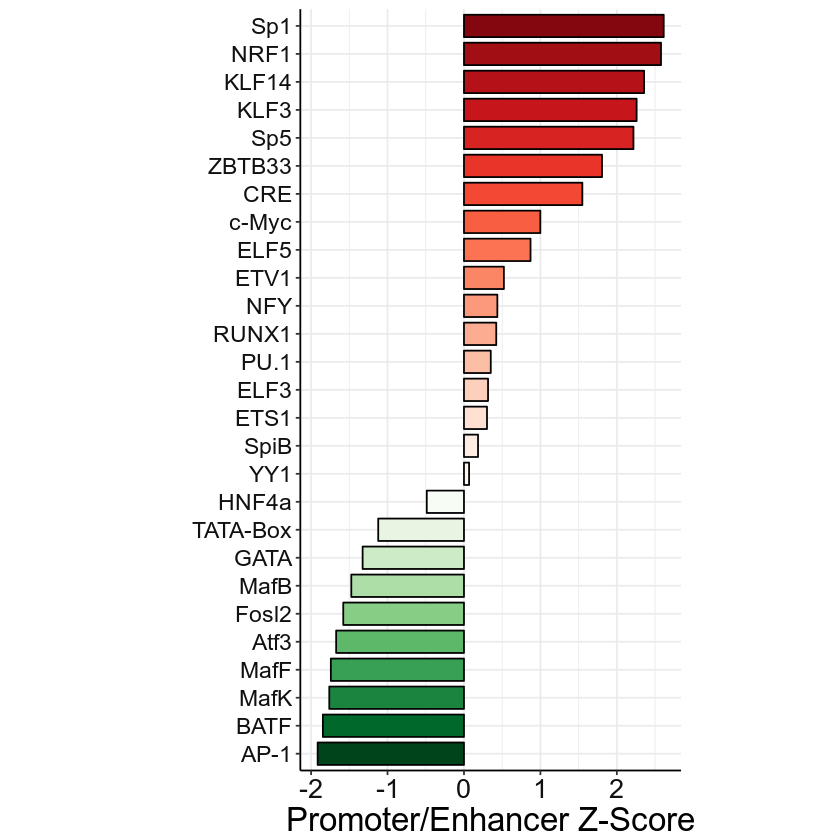

In [4]:
df$tf <- factor(df$tf, levels = df$tf[order(df$ratio)])

colourCount = length(unique(df$tf))
getPaletteRd = colorRampPalette(brewer.pal(9, "Reds"))
getPaletteGn = colorRampPalette(brewer.pal(9, "Greens"))

p <- ggplot(df, aes(x = tf, y = ratio)) +
        geom_col(aes(fill=tf), colour='black', width=0.8) +
        labs(y = 'Promoter/Enhancer Z-Score', x = '')
p <- p + scale_fill_manual(values = c(rev(getPaletteGn(10)), getPaletteRd(18)))
# p <- p + coord_flip(ylim=c(0, 1.05))
p <- p + coord_flip()
p <- p + theme_bw()
p <- p + theme(aspect.ratio=2)
# p <- p + scale_x_discrete(name = "Promoter/Enhancer", 
# #                           breaks = waiver(), 
#                           limits = c('0.75', '1.00', '1.25', '1.5'), 
# #                           limits = c(0, 2)
#                          )
p <- p + theme(
               axis.line = element_line(colour = "black"),
               axis.title=element_text(size=20),
               axis.text.y=element_text(size=14, colour='#111111'),
               axis.text.x=element_text(size=16, colour='#111111'),
               panel.border = element_blank(),
            )
p <- p + guides(fill=FALSE, color=FALSE)
p

ggsave("../plots/deeplift/regGrammars/promoterEnhancerZScoreBarplot_sep17.png",
       scale = 1,
       plot = p,
       units = "in", dpi=1000)

# Motif score boxplot Fig 6c

In [1]:
df = read.csv('../plots/deeplift/motif_boxplots/ETS_HNF_REST_data.csv', header = TRUE)

In [2]:
head(df)

X,motif,score,task
0,ETS,0.0017323120,"K562, real motif"
1,ETS,0.0068530249,"K562, real motif"
2,ETS,0.0014950467,"K562, real motif"
3,ETS,0.0087563545,"K562, real motif"
4,ETS,0.0007821653,"K562, real motif"
5,ETS,0.0079582296,"K562, real motif"


Saving 8 x 8 in image


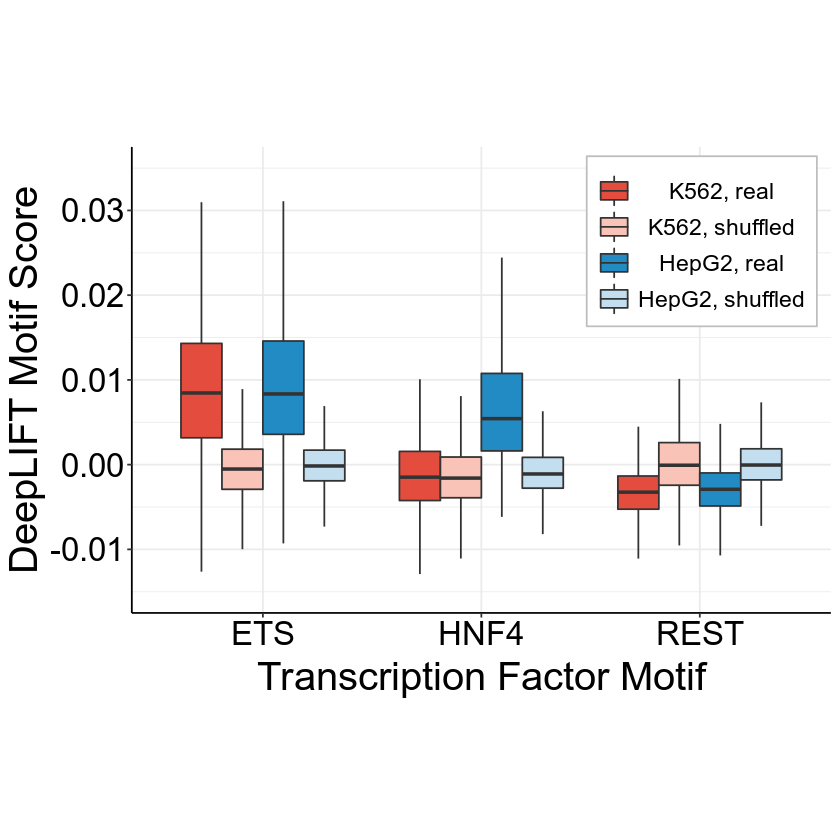

In [7]:
# cols <- c('#b92f2b', '#e7aa64', '#579352', '#4166a6'
taskOrder = c('K562, real motif', 'K562, shuffled motif', 'HepG2, real motif', 'HepG2, shuffled motif')
# sortedDf <- data.frame(df$task[order(match(df$task, taskOrder))])
sortedDf <- arrange(df, order(match(df$task, taskOrder)))
sortedDf$task <- factor(sortedDf$task, levels = taskOrder, ordered = TRUE)

scale <- c(1.2)

cols <- c('#E44D3D', '#F9C3B8', '#238BC3', '#c3deef')
p <- ggplot(sortedDf, aes(x = motif, y = score, fill = task)) +
        geom_boxplot(outlier.shape = NA) + 
        coord_cartesian(ylim = c(-0.015, 0.035)) +
        labs(x = 'Transcription Factor Motif', y = 'DeepLIFT Motif Score')
p <- p + scale_fill_manual(labels=c('K562, real', 'K562, shuffled', 'HepG2, real', 'HepG2, shuffled'),
                           values=cols)
p <- p + theme_bw()
p <- p + theme(
#                panel.grid.major=element_line(colour='#F1F1F1'),
#                panel.grid.minor=element_line(colour='#F1F1F1'),
               panel.border = element_blank(),
#                panel.background=element_rect(size=0.5, colour='black')
            )
p <- p + theme(aspect.ratio=3/4.5)
p <- p + theme(
#                panel.grid.major = element_blank(), 
#                panel.grid.minor = element_blank(),
               axis.line = element_line(colour = "black"),
               legend.position=c(0.98,0.98),
               legend.title=element_blank(),
               legend.justification=c(1, 1),
               legend.key.size=unit(0.045, 'npc'),
               legend.text=element_text(size=14),
               legend.text.align = 0.5,
               legend.background=element_rect(fill='white', size=0.5, colour='grey'),
               axis.title=element_text(size=20*scale),
               axis.text=element_text(size=16.7*scale, colour='#000000'),
            )
# p <- p + guides(fill = guide_legend(label.position = "right", 
#                                     label.vjust = 0.5,
#                                     label.hjust = 0.0,
#                                     label = TRUE)) 
p <- p + theme(axis.title.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)))
p

ggsave("../plots/deeplift/motif_boxplots/ETS_HNF_REST_boxplot_correctBorder_biggerLegendText.png",
       scale = scale,
       plot = p,
       units = "in", dpi=1000)

In [ ]:
wilcox.test(df[df$motif %in% c('ETS'),]['score'])

In [228]:
head(df[which(df$motif %in% c('ETS'))])

ERROR: Error in `[.data.frame`(df, which(df$motif %in% c("ETS"))): undefined columns selected


In [232]:
head(df[df$motif %in% c('ETS'),]['score'])

score
0.0017323120
0.0068530249
0.0014950467
0.0087563545
0.0007821653
0.0079582296


# Sharpr scores at controls, motifs, and deepLIFT hits violinplot Fig 6e

In [2]:
df = read.csv('../data/sharprScores/controlMotifDeeplift_sharprScoreComparison_subsampled.csv', header = TRUE)
head(df)

X,score,type
0,-0.2535833,Control
1,-0.2848572,Control
2,-0.3473750,Control
3,-0.3647500,Control
4,-0.3830000,Control
5,-0.1446667,Control


In [3]:
## Summarizes data.
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr); library(dplyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

type,N,score,sd,se,ci
DeepLIFT Hit,2129,1.0778276,1.7009966,0.036865117,0.072295421
Motif Hit,105457,0.4872872,0.8187213,0.002521148,0.004941416
Control,205809,0.3502921,0.5676211,0.001251199,0.002452319


Saving 6.67 x 6.67 in image


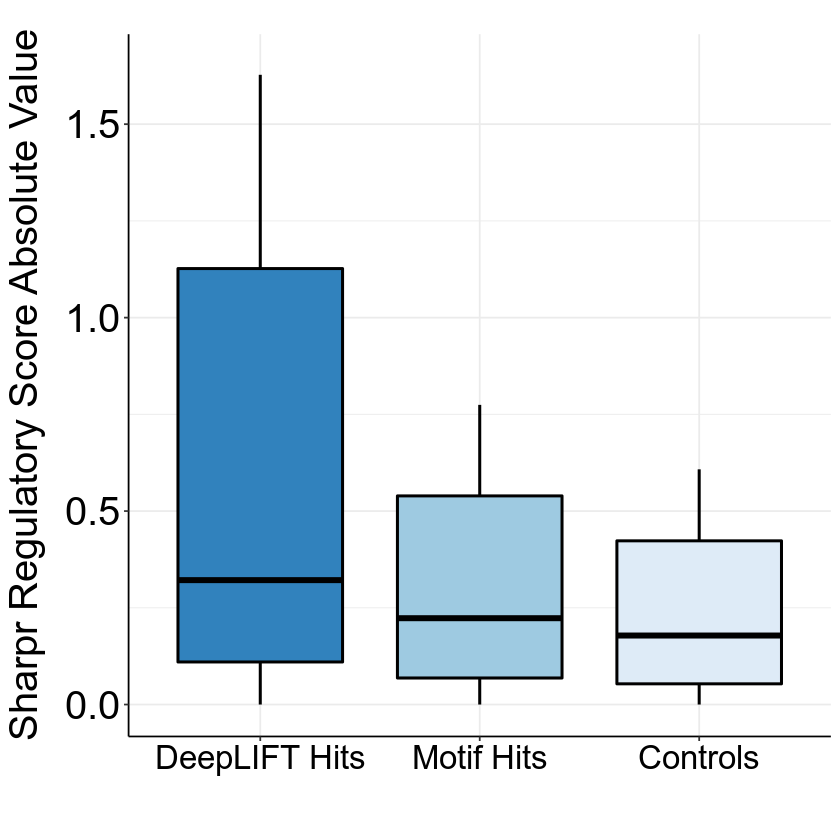

In [34]:
se <- function(x){sd(x)/sqrt(length(x))}

# cols <- c('#b92f2b', '#e7aa64', '#579352', '#4166a6'
typeOrder = c('DeepLIFT Hit', 'Motif Hit', 'Control')
# df <- arrange(df, order(match(df$type, typeOrder)))
df$score <- abs(df$score)
df$type <- factor(df$type, levels = typeOrder, ordered = TRUE)

# df_bar <- summarise(group_by(df, type), mean_score = mean(score), se_score = se(score))
df_bar <- summarySE(df, measurevar="score", groupvars=c("type"))
head(df_bar)

scale <- c(1)

cols <- c('#21329D', '#4275C9', '#75B3F9')
# p <- ggplot(df_bar, aes(x=type, y=score, fill=type)) +
#         geom_bar(stat="identity",
#                  colour='black') +
#         geom_errorbar(aes(ymin=score-se, ymax=score+se), width=.1) +
#         labs(x = '', y = 'Sharpr-MPRA Regulatory Activity Score')
p <- ggplot(df) +
#         geom_violin(aes(x=type, y=score, fill=type), trim = TRUE, lwd=0.7, scale='width', width=0.7) + 
#         scale_color_brewer(palette="Blues", direction = -1) +
#         geom_boxplot(aes(x=type, y=score, color=type), outlier.shape = NA, fill=NA, coef=0, lwd=1) +
#         scale_color_manual(values=cols) + 
          geom_boxplot(aes(x=type, y=score, fill=type), outlier.shape = NA, color = 'black', coef=0.5, lwd=0.85) +
          scale_fill_brewer(palette="Blues", direction = -1) +
#         scale_y_continuous(limits = c(0.0, 3.0)) +
        coord_cartesian(ylim = c(0.0, 1.65)) +
        labs(x = '', y = 'Sharpr Regulatory Score Absolute Value')
p <- p + scale_x_discrete(labels=c('DeepLIFT Hits', 'Motif Hits', 'Controls'))
# p <- p + scale_fill_manual(values=cols)
# p <- p + scale_fill_brewer(palette="Blues", direction = -1)
p <- p + theme_bw()
p <- p + theme(aspect.ratio=1)
p <- p + theme(
               axis.line = element_line(colour = "black"),
               axis.title=element_text(size=24*scale),
               axis.text.y=element_text(size=24*scale, colour='#000000'),
               axis.text.x=element_text(size=20*scale, colour='#000000'),
               panel.border = element_blank(),
#                panel.background=element_rect(size=0.3, colour='black')
            )
# p <- p + theme(panel.grid.minor = element_blank(),
#                panel.grid.major = element_blank())
p <- p + theme(axis.title.y = element_text(margin = margin(t = 0, r = 15, b = 0, l = 0)))
p <- p + guides(fill=FALSE, color=FALSE)
p

ggsave("../plots/deeplift/controlMotifDeeplift_sharprScoreComparison_boxplot.png",
       scale = scale,
       plot = p,
       units = "in", dpi=600)

abs(df$score)[c(1:10)]

In [50]:
means <- aggregate(score ~ type, df, mean)
means

type,score
DeepLIFT Hit,1.0778276
Motif Hit,0.4872872
Control,0.3502921
